<a href="https://colab.research.google.com/github/ggrgrtr/Machine-learning-sine-and-complex-function/blob/main/%D0%92%D0%B8%D0%BD%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import torch
import numpy as np

# установение постоянной случайности
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [2]:
# импортироание датасетов для обучения н.с.
import sklearn.datasets
wine=sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
# импортирование train_test_split для передаче массивов данных, разбитых по категориям
from sklearn.model_selection import train_test_split

x_train,x_test,y_train, y_test =train_test_split(wine.data[:, :2],wine.target,test_size=0.3,shuffle=True,stratify = wine.target)


# переопределение массивов в тензоры
x_train=torch.FloatTensor(x_train)
x_test=torch.FloatTensor(x_test)

y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)


device = torch.device('cuda:0'
                      if torch.cuda.is_available()
                      else 'cpu')
x_train=x_train.to(device)
y_train=y_train.to(device)
x_test=x_test.to(device)
y_test=y_test.to(device)


In [4]:
class WineNet(torch.nn.Module):
  def __init__(self, n):
    super(WineNet,self).__init__() # подбираем оптимльное кол-во скрытых слоев

    self.f1=torch.nn.Linear(2,n)
    self.act1=torch.nn.Sigmoid()

    # РУЧНАЯ ПАРАМЕТРОТИЗАЦИЯ ПРОГРАММЫ
    # self.f2=torch.nn.Linear(n,n)
    # self.act2=torch.nn.Sigmoid()

    self.f3=torch.nn.Linear(n,3)

    self.softChance=torch.nn.Softmax(dim=1)

  #
  def forward(self,x):
    x=self.f1(x)
    x=self.act1(x)
    # x=self.f2(x)
    # x=self.act2(x)
    x=self.f3(x)
    return x

  def inference(self,x):
    x=self.forward(x)
    x=self.softChance(x)
    return x


net=WineNet(5)

loss_f=torch.nn.CrossEntropyLoss() # Ф. потерь: кросс-энтропия

method_of_grad_steps=torch.optim.Adam(net.parameters(),lr=1.0e-3)

In [5]:
np.random.permutation(5)

array([3, 2, 1, 4, 0])

In [6]:
batch_size=10 # куча - 10 эл.

pr1=0
for epoch in range(5000): # использование кусочного обучения
  order_train =np.random.permutation(len(x_train)) # создание списка перемешанных индексов для взятия значений трнировочного Тензора
  # order_train=order_train.to(device)

  for start_i in range(0,len(x_train),batch_size):
    method_of_grad_steps.zero_grad() # обнуение градиента для нахождения нового

    batches_i =order_train[start_i:start_i+batch_size]  # создание кучи из 10 индексов
    x_batch_data =x_train[batches_i]                    # взятие элементов кучи (параметров начального тензора)
    x_batch_data=x_batch_data.to(device)
    y_batch_data =y_train[batches_i]                    # взятие элементов-таргетов кучи (результата)

    # обучение н.с. по /куче/ параметров
    predictions =net.forward(x_batch_data)

    loss_val =loss_f(predictions,y_batch_data)
    loss_val.backward()

    method_of_grad_steps.step() # шаг градиентного спуска

  if epoch%100==0:
    test_preds =net.forward(x_test)
    test_preds =test_preds.argmax(dim=1) #показывает какой выход был с наиб. знач. -> с высшей вероятностью
    pr1=(test_preds==y_test).float().mean()
    print(pr1) # ср. зн. тензора сопадений тензоров


tensor(0.3889)
tensor(0.4815)
tensor(0.5370)
tensor(0.6111)
tensor(0.6667)
tensor(0.6852)
tensor(0.7593)
tensor(0.7593)
tensor(0.7593)
tensor(0.7778)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.7593)
tensor(0.7778)
tensor(0.7778)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8519)
tensor(0.8889)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)


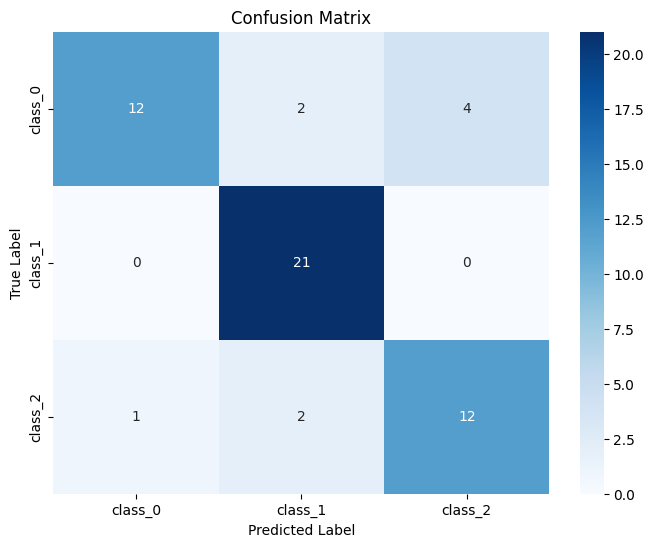

Classification Report:
              precision    recall  f1-score   support

     class_0       0.92      0.67      0.77        18
     class_1       0.84      1.00      0.91        21
     class_2       0.75      0.80      0.77        15

    accuracy                           0.83        54
   macro avg       0.84      0.82      0.82        54
weighted avg       0.84      0.83      0.83        54



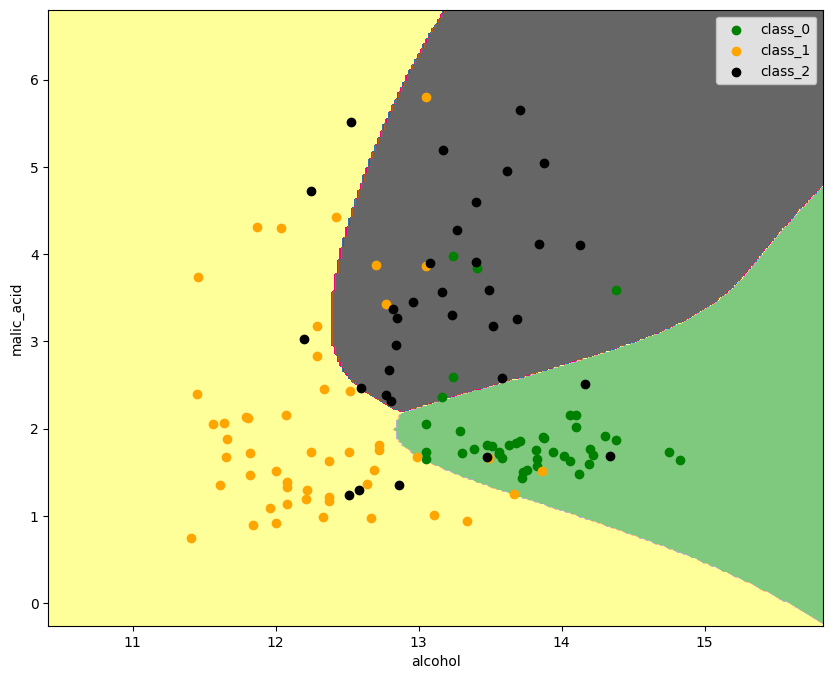

In [12]:
import matplotlib.pyplot as plt




# покажем важные характеристики обучения
# Предсказания на тестовых данных
with torch.no_grad():
    probabilities = net.inference(x_test)
    predicted_classes = probabilities.argmax(dim=1).cpu().numpy()

# Матрица ошибок
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test.cpu().numpy(), predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=wine.target_names,
            yticklabels=wine.target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print("Classification Report:")
print(classification_report(y_test.cpu().numpy(), predicted_classes,
                          target_names=wine.target_names))


%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(x_train[indexes, 0],
                x_train[indexes, 1],
                c=color,
                label=wine.target_names[i])
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()



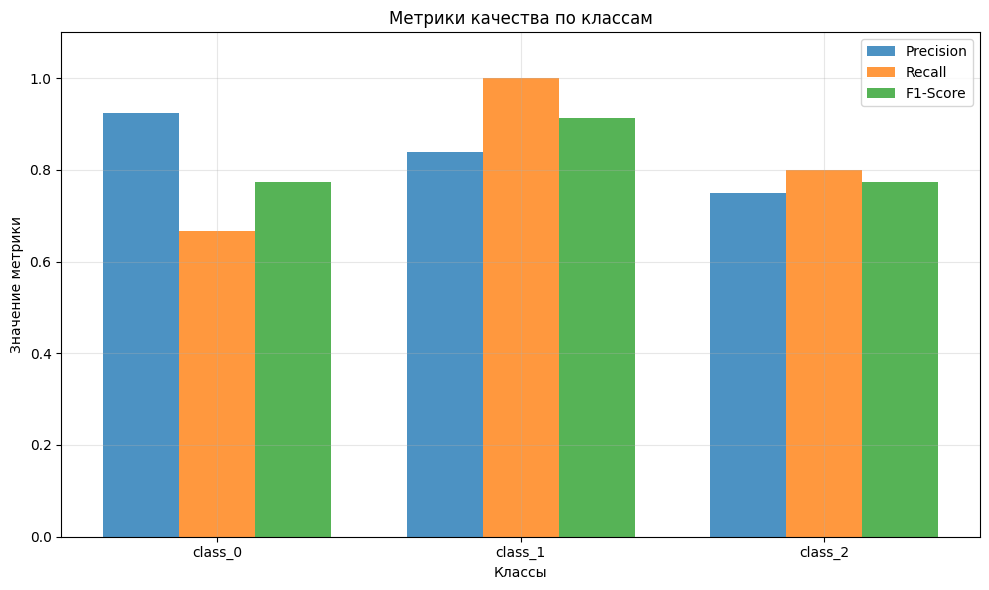

In [10]:
from sklearn.metrics import precision_recall_fscore_support

# Вычисляем метрики для каждого класса
precision, recall, f1, support = precision_recall_fscore_support(
    y_test.cpu().numpy(), test_preds, average=None)

# График сравнения метрик по классам
metrics = ['Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(wine.target_names))

plt.figure(figsize=(10, 6))
width = 0.25

plt.bar(x_pos - width, precision, width, label='Precision', alpha=0.8)
plt.bar(x_pos, recall, width, label='Recall', alpha=0.8)
plt.bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8)

plt.xlabel('Классы')
plt.ylabel('Значение метрики')
plt.title('Метрики качества по классам')
plt.xticks(x_pos, wine.target_names)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()